# GLM Demo: multivariate song stimulus, biophysical dynamics

This demo adds biophysical dynamics to the simulation.

In [1]:
from __future__ import print_function, division
import os
import sys
import numpy as np

import mat_neuron._model as mat
from dstrf import io, strf, mle, simulate, stimulus, filters, models, spikes, performance

# plotting packages
%reload_ext yamlmagic
%matplotlib inline
import matplotlib.pyplot as plt # plotting functions
import seaborn as sns           # data visualization package
sns.set_style("whitegrid")

cfg = {}

Set up parameters using YAML and Munch

In [13]:
%%yaml cfg
model:
  dt: 0.5
  ataus: [10.0, 200.0]
  t_refract: 2.0
  filter:
    rank: 2
    len: 30
    ncos: 8
  prior:
    l1: 50
    l2: 5
data:
  stimulus:
    source: "crcns"
    root: "/Users/dmeliza/Documents/projects/dstrf/crcns"
    cell: "blabla0903_2_B"
    stim_type: "conspecific"
    spectrogram:
      window: 2.5
      compress: 10
      f_min: 0
      f_max: 8000
      gammatone: False
  model: "multivariate_dynamical"
  dynamics:
    model: "../../models/biocm_tonic.yml"
    current_scaling: 20.0
  filter:
    fn: "hg"
    nfreq: 20
    ntau: 30
    ampl: 1
    f_max: 8000
    f_peak: 2844
    f_sigma: 1504
    f_omega: 0.0001329
    t_max: 30
    t_peak: 8.19517332914
    t_sigma: 4.3656196941
    t_omega: 0.04398
    Pt: 1.571
    Pf: 0.0
  adaptation: [7.0, 100.0, 2.0]
  trial_noise:
    color: pink
    sd: 4.0
  random_seed: 1
  dt: 1.0
  trials: 10
  test_proportion: 0.2
spike_detect:
  thresh: -20.0
  rise_dt: 1.0

<IPython.core.display.Javascript object>

In [14]:
from munch import munchify
cf = munchify(cfg)

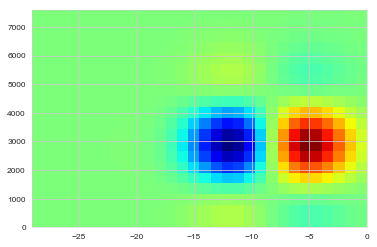

In [15]:
import imp
imp.reload(filters)
k1, k1t, k1f = filters.hg(**cf.data.filter)
plt.imshow(k1, extent=(k1t[0], k1t[-1], k1f[0], k1f[-1]), cmap='jet', aspect='auto');

The simulation code has been factored out to the `simulate` module. We're going to split the data into assimilation and test sets.

In [16]:
stim_data = stimulus.crcns(cf)
n_test = int(cf.data.test_proportion * len(stim_data))

assim_data = io.merge_data(simulate.multivariate_dynamical(cf, stim_data[:-n_test]))

 - stimulus dimension: 20
 - dynamical model: ../../models/biocm_tonic.yml


In [17]:
print("duration:", assim_data["duration"])
print("stim bins:", assim_data["stim"].shape[1])
print("spike bins:", assim_data["spike_v"].shape[0])
print("I_max:", np.max(assim_data["I"]))
print("total spikes:", np.sum(assim_data["spike_v"]))

duration: 31572.0
stim bins: 31572
spike bins: 63144
I_max: 561.257963698065
total spikes: 2247


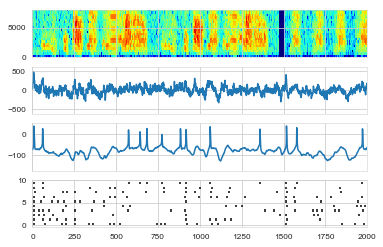

In [18]:
t_stim = np.linspace(0, assim_data["duration"], assim_data["stim"].shape[1])
t_spike = np.linspace(0, assim_data["duration"], assim_data["spike_v"].shape[0])

fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(6, 4))
axes[0].imshow(assim_data["stim"], 
               extent=(0, assim_data["duration"], cf.data.stimulus.spectrogram.f_min, cf.data.stimulus.spectrogram.f_max),
               cmap='jet', origin='lower', aspect='auto')
axes[1].plot(t_stim, assim_data["I"])
axes[2].plot(t_spike, assim_data["V"])
for i, spk in enumerate(assim_data["spike_t"]):
    axes[3].vlines(spk * cf.model.dt, i, i + 0.5)

axes[0].set_xlim(0, 2000);

## Estimate parameters

Construct the factorized ML estimator.

In [19]:
# initial guess of parameters using ML
krank = cf.model.filter.rank
kcosbas = strf.cosbasis(cf.model.filter.len, cf.model.filter.ncos)
try:
    mlest = mle.matfact(assim_data["stim"], kcosbas, krank, assim_data["spike_v"], assim_data["spike_h"],
                        assim_data["stim_dt"], assim_data["spike_dt"])
except TypeError:
    mlest = mle.matfact(assim_data["stim"], kcosbas, krank, assim_data["spike_v"], assim_data["spike_h"],
                        assim_data["stim_dt"], assim_data["spike_dt"])    

The reg_alpha and reg_lambda parameters set the L1 and L2 penalties for the initial ML estimation. We'll start with some fairly moderate regularization just to get an initial estimate.

In [20]:
%time w0 = mlest.estimate(reg_lambda=cf.model.prior.l2, reg_alpha=cf.model.prior.l1)

Optimization terminated successfully.
         Current function value: 11638.537298
         Iterations: 64
         Function evaluations: 128
         Gradient evaluations: 191
         Hessian evaluations: 296
CPU times: user 19.1 s, sys: 1.68 s, total: 20.8 s
Wall time: 19.3 s


MLE rate and adaptation parameters: [ 5.44971124  6.80040089 -0.47012062]


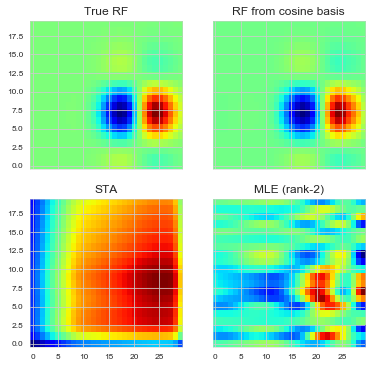

In [21]:
print("MLE rate and adaptation parameters:", w0[:3])
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(6, 6))

k1c = strf.to_basis(k1, kcosbas)
rf_sta = strf.as_matrix(mlest.sta(), kcosbas)
rf_mle = strf.from_basis(strf.defactorize(w0[3:], cf.data.filter.nfreq, krank), kcosbas)
axes[0, 0].imshow(k1, cmap='jet', aspect='auto')
axes[0, 0].set_title("True RF")
axes[0, 1].imshow(strf.from_basis(k1c, kcosbas), cmap='jet', aspect='auto')
axes[0, 1].set_title("RF from cosine basis")
axes[1, 0].imshow(rf_sta, cmap='jet', aspect='auto')
axes[1, 0].set_title("STA")
axes[1, 1].imshow(rf_mle, cmap='jet', aspect='auto')
axes[1, 1].set_title("MLE (rank-{})".format(krank));

We're now going to select regularization parameters using cross-validation. This makes use of the scikit-learn package.

In [24]:
import progressbar
from dstrf import crossvalidate

#reg_grid = np.logspace(-1, 5, 50)[::-1]
l1_ratios = [0.1, 0.5, 0.7, 0.9, 0.95]
reg_grid = np.logspace(-1, 5, 20)[::-1]
scores = []
results = []

bar = progressbar.ProgressBar(max_value=len(l1_ratios) * len(reg_grid),
                              widgets=[
                                ' [', progressbar.Timer(), '] ',
                                progressbar.Bar(),
                                ' (', progressbar.ETA(), ') ',
                            ])
for reg, s, w in bar(crossvalidate.elasticnet(mlest, 4, reg_grid, l1_ratios, avextol=1e-5, disp=False)):
    scores.append(s)
    results.append((reg, s, w))
    
best_idx = np.argmax(scores)
(rf_alpha, rf_lambda), ll, w0 = results[best_idx]

 [Elapsed Time: 0:10:14] |##################################| (Time:  0:10:14) 


best regularization params: alpha=0.04281332398719394, lambda=0.3853199158847454
MLE rate and adaptation parameters: [ 5.46828092  8.22339008 -0.49883905]


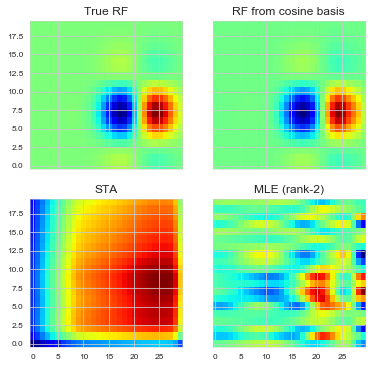

In [25]:
print("best regularization params: alpha={}, lambda={}".format(rf_alpha, rf_lambda))
print("MLE rate and adaptation parameters:", w0[:3])
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(6, 6))

k1c = strf.to_basis(k1, kcosbas)
rf_sta = strf.as_matrix(mlest.sta(), kcosbas)
rf_mle = strf.from_basis(strf.defactorize(w0[3:], cf.data.filter.nfreq, krank), kcosbas)
axes[0, 0].imshow(k1, cmap='jet', aspect='auto')
axes[0, 0].set_title("True RF")
axes[0, 1].imshow(strf.from_basis(k1c, kcosbas), cmap='jet', aspect='auto')
axes[0, 1].set_title("RF from cosine basis")
axes[1, 0].imshow(rf_sta, cmap='jet', aspect='auto')
axes[1, 0].set_title("STA")
axes[1, 1].imshow(rf_mle, cmap='jet', aspect='auto')
axes[1, 1].set_title("MLE (rank-{})".format(krank));

## Predict responses

In [22]:
test_data = io.merge_data(simulate.multivariate_dynamical(cf, stim_data[-n_test:]))
mltest = mle.matfact(test_data["stim"], kcosbas, krank, test_data["spike_v"], test_data["spike_h"],
                     test_data["stim_dt"], test_data["spike_dt"])

 - stimulus dimension: 20
 - dynamical model: ../../models/biocm_tonic.yml


EO cc: 0.290
pred cc: 0.415
spike count: data = 586, pred = 757


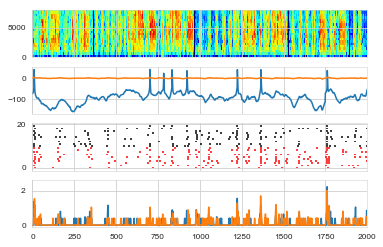

In [26]:
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True)
axes[0].imshow(assim_data["stim"], 
               extent=(0, test_data["duration"], cf.data.stimulus.spectrogram.f_min, cf.data.stimulus.spectrogram.f_max),
               cmap='jet', origin='lower', aspect='auto')

t_stim = np.linspace(0, test_data["duration"], test_data["stim"].shape[1])
t_spike = np.linspace(0, test_data["duration"], test_data["spike_v"].shape[0])
#V = strf.convolve(test_data["stim"], k1)
Vpred = mltest.V(w0)
axes[1].plot(t_spike, test_data["V"], t_stim, Vpred)

n_trials = test_data["ntrials"]
for i, spk in enumerate(test_data["spike_t"]):
    axes[2].vlines(spk * cf.model.dt, i - 0.4 + n_trials, i + 0.4 + n_trials)
pred = np.zeros_like(test_data["spike_v"])
for j in range(n_trials):
    pred[:, j] = models.predict_spikes_glm(Vpred, w0[:3], cf)
    spk_t = pred[:, j].nonzero()[0]
    axes[2].vlines(spk_t * cf.model.dt, j - 0.4, j + 0.4, color='r')

upsample = int(cf.data.dt / cf.model.dt)   
pred_psth = spikes.psth(pred, upsample, 1)
test_psth = spikes.psth(test_data["spike_v"], upsample, 1)
axes[3].plot(t_stim, test_psth, t_stim, pred_psth)
axes[3].set_xlim(0, 2000);

eo = performance.corrcoef(test_data["spike_v"][::2], test_data["spike_v"][1::2], upsample, 1)
print("EO cc: %3.3f" % eo)
print("pred cc: %3.3f" % np.corrcoef(test_psth, pred_psth)[0, 1])
print("spike count: data = {}, pred = {}".format(test_data["spike_v"].sum(), pred.sum()))